<a href="https://colab.research.google.com/github/tmsandford/M33_Matching/blob/main/Index_Match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install --upgrade pip
!pip install vaex
!pip install -Iv ipython==7.0.0
!pip install astroquery
!sudo pip install numpy --upgrade --ignore-installed

##### MAKE SURE TO 'RESTART RUNTIME' #####

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import ascii,fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from scipy.interpolate import UnivariateSpline
import matplotlib.patches as patches
import matplotlib.path as path
import vaex
from astropy.coordinates import Angle
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astroquery.irsa import Irsa
from ipywidgets import interact

# Set up matplotlib standard parameters
params = {'figure.figsize': (10,10),
          'text.usetex': False,
          'font.family': 'serif',
          'xtick.direction': 'in',
          'xtick.top': True,
          'xtick.labelsize': 22,
          'ytick.direction': 'in',
          'ytick.right': True,
          'ytick.labelsize': 22,
          'axes.titlesize': 40,
          'axes.labelsize': 40,
          'axes.spines.left': True,
          'axes.spines.bottom': True,
          'axes.spines.top': True,
          'axes.spines.right': True,
          'axes.grid.axis': 'both',
          'axes.grid.which': 'both'}
mpl.rcParams.update(params)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')
datadir = '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


In [3]:
ds = vaex.open(datadir+'M33_full_matched.hdf5')
ds.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25)', name='IR_GST')
ds.select('(RA > 23.43) & (RA < 23.6) & '
          '(DEC > 30.71) & (DEC < 30.81) & '
          'IR_GST',name='SUB')

ra,dec = ds.RA.evaluate(selection='SUB'),ds.DEC.evaluate(selection='SUB')

In [5]:
def setup(ra_min=23.43, ra_max=23.45, dec_min=30.71, dec_max=30.72):
        ###plots unWISE sources
    
    Irsa.ROW_LIMIT = 100000
    #table = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon", radius=0.25*u.deg)
    global table
    table = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=23.43,dec=30.71,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.6,dec=30.71,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.6,dec=30.81,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.43,dec=30.81,unit=(u.deg,u.deg),frame='icrs')])
    
    table.add_index('ra')

    selected = table[(table['ra'] > ra_min) & (table['ra'] < ra_max) & (table['dec'] > dec_min) & (table['dec'] < dec_max)]
    plot_index = selected['ra']
    
    
    fig = plt.figure()
    fig.set_figwidth(30)
    fig.set_figheight(20)
    ax = plt.subplot(111)
    ax.set_xlabel('RA', fontsize=25)
    ax.set_ylabel('Dec', fontsize=20)

    s = ax.scatter(selected['ra'],selected['dec'],s=10,c='black')

    ax.set_xlim(ax.get_xlim()[::-1])
    
    x,y = table['ra'],table['dec']

    global index_title
    index_title = []

    for i in plot_index:
        ind = table.loc_indices[i]
        plt.text(x[ind] - 0.00005,y[ind],ind, fontsize='xx-large', in_layout=True)
        index_title.append(ind)
        

    
    global points
    points = s.get_offsets()
    points = points[:,0].data

In [6]:
def phatter_sources(index, title):
  delta_ra = (ra - table['ra'][index])*np.cos(np.pi/180 * table['dec'][index])
  delta_dec = dec - table['dec'][index]
  wh = np.where( np.sqrt(delta_ra**2 + delta_dec**2) <= 6.0/3600 )
  ds['F110W_F160W'] = ds.F110W_VEGA - ds.F160W_VEGA
  F110W_F160W,F160W = ds.F110W_F160W.evaluate(selection='SUB'),ds.F160W_VEGA.evaluate(selection='SUB')

  cmd_title = 'unWISE Index: ' + str(index_title[title])

  fig = plt.figure()
  fig.set_figwidth(10)
  fig.set_figheight(10)
  ax = plt.subplot(111)
  ax.set_xlabel('F110W-F160W')
  ax.set_ylabel('F160W')
  ax.set_title(cmd_title, loc='center', pad=5)
  ax.set_xlim(-1,2.5)
  ax.set_ylim(26,13)
  ax.scatter(F110W_F160W[wh],F160W[wh],s=10,c='black')

In [7]:
def phatter_cmd(wise_ra, title):
  """takes input RA from WISE and returns PHATTER plot of sources in same area"""
  wise_index = np.where(table['ra'] == wise_ra)
  phatter_sources(wise_index, title)

In [8]:
def sources(start=0, stop=2):
    interact(setup, ra_min=(23.43, 23.6, 0.01), ra_max=(23.431, 23.6, 0.01), 
         dec_min=(30.71, 30.81, 0.01), dec_max=(30.711, 30.81, 0.01))
 
    points_ra = points

    for x in range(start, stop):
      index = points_ra[x]
      phatter_cmd(index, x)


interactive(children=(FloatSlider(value=23.43, description='ra_min', max=23.6, min=23.43, step=0.01), FloatSli…

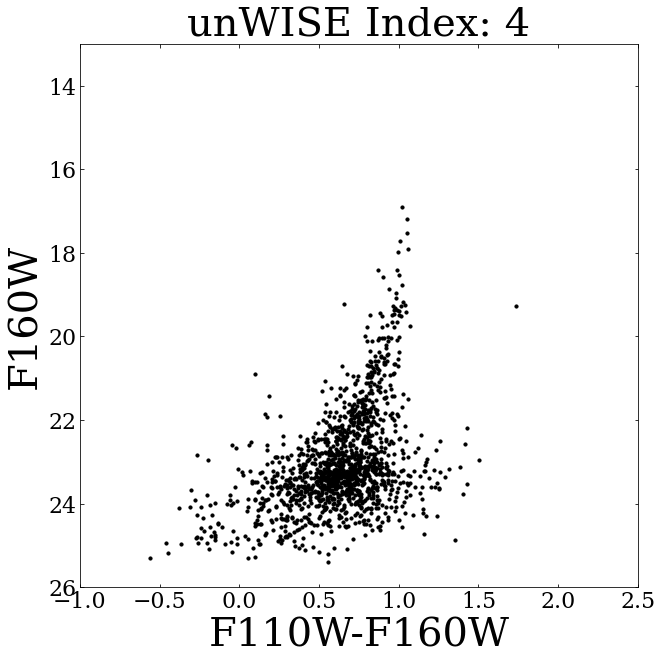

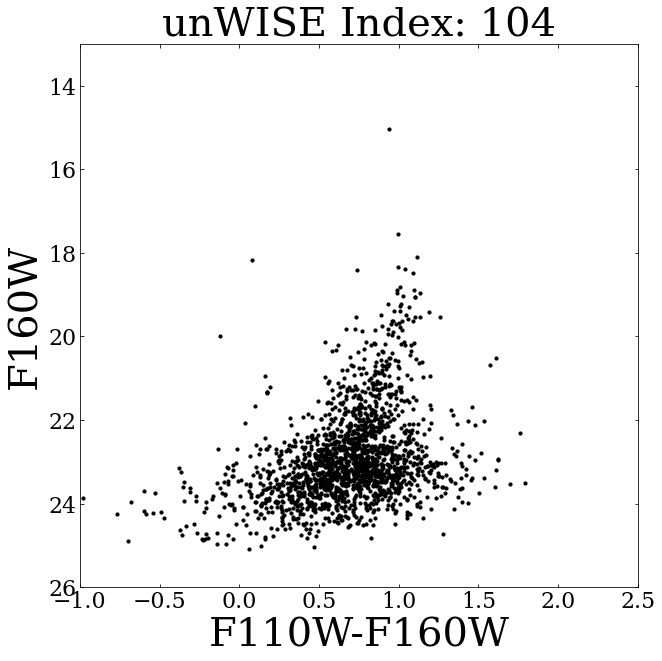

In [10]:
sources()

interactive(children=(FloatSlider(value=23.43, description='ra_min', max=23.6, min=23.43, step=0.01), FloatSli…

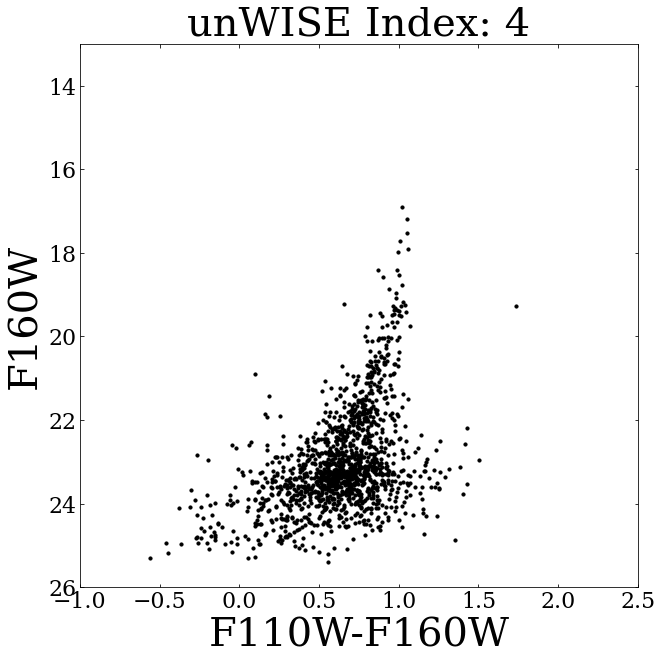

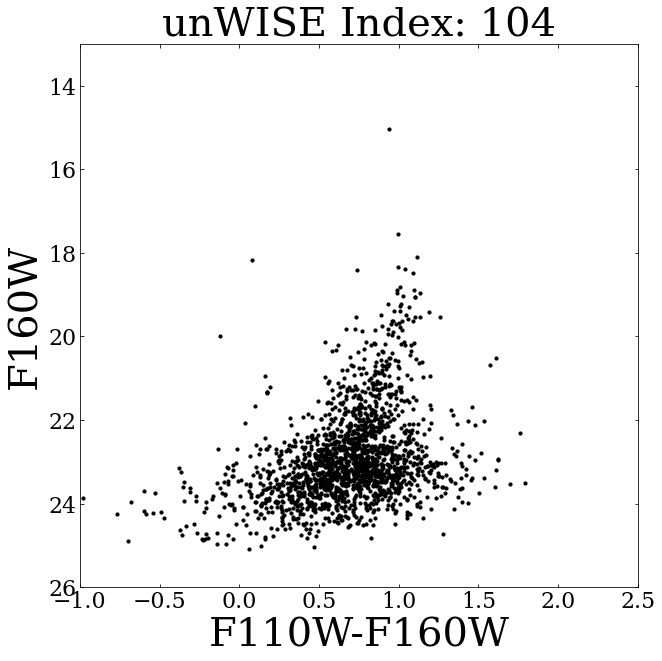

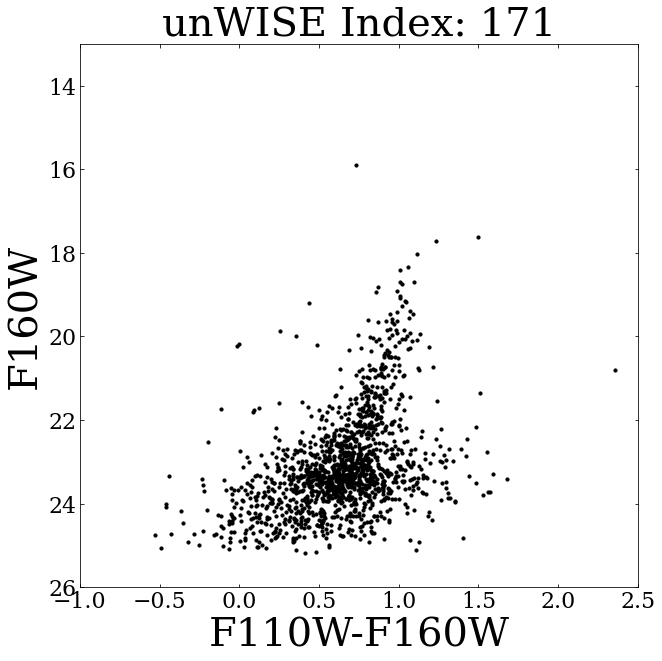

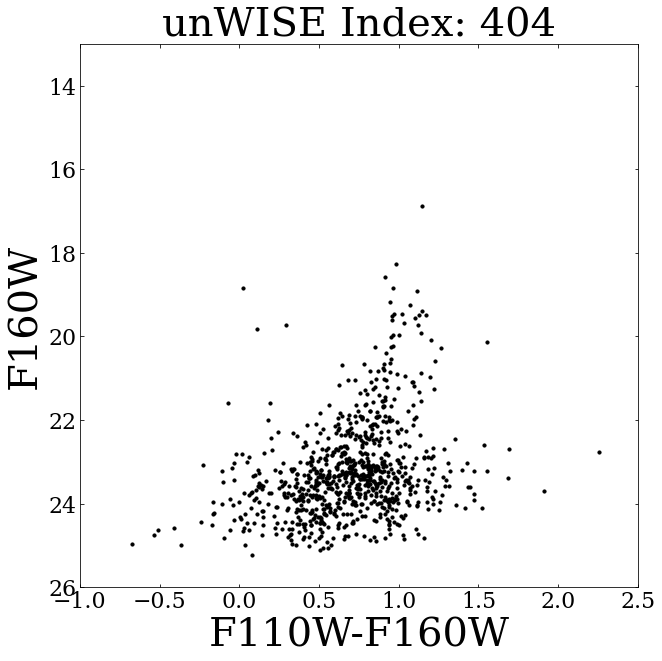

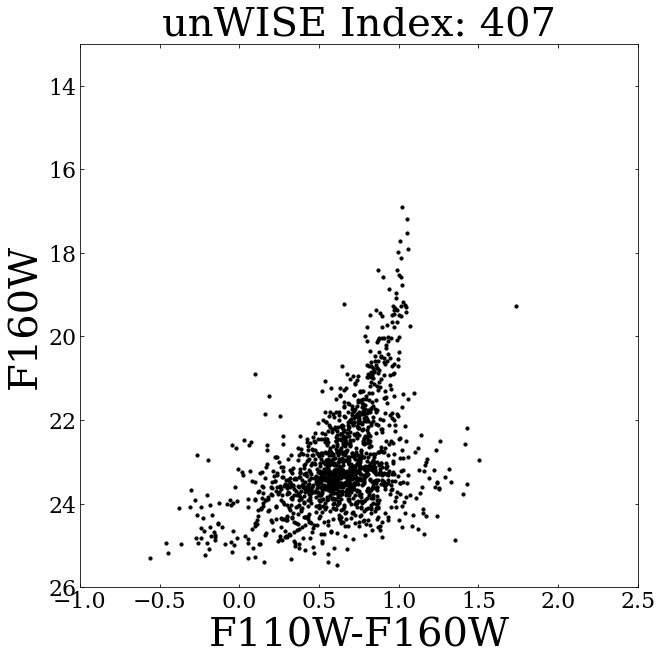

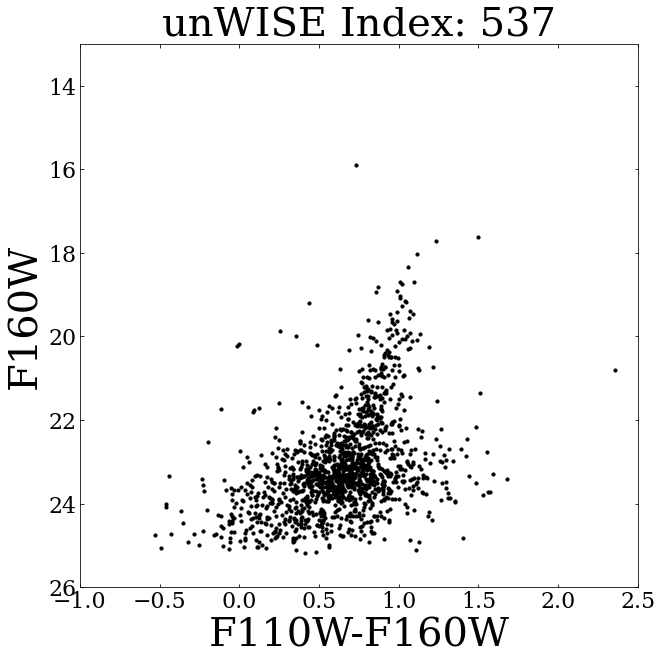

In [11]:
sources(0,6)